##**REQUIREMENTS**

In [ ]:
!pip install face_detection

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.7 MB/s eta 0:00:00


In [ ]:
!pip3 install scikit-learn

In [ ]:
!pip install dlib

In [ ]:
!pip install face-recognition

##**DETECTION AND CROPPING**

In [ ]:
import cv2
import os
from mtcnn import MTCNN  # Make sure you have installed mtcnn library
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread('/content/classroom3.jpg')

# Load the pre-trained face detection model from MTCNN
detector_mtcnn = MTCNN()

# Detect faces using MTCNN
faces_mtcnn = detector_mtcnn.detect_faces(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Create a folder to store cropped faces
output_folder = 'cropped_faces2'
os.makedirs(output_folder, exist_ok=True)

# Crop and save each detected face
for i, face in enumerate(faces_mtcnn):
    x, y, width, height = face['box']
    # Calculate new box coordinates
    x_new = max(0, x - int(width * 0.25))
    y_new = max(0, y - int(height * 0.25))
    width_new = int(width * 1.5)
    height_new = int(height * 1.5)
    # Crop the face region from the image
    cropped_face = image[y_new:y_new+height_new, x_new:x_new+width_new]
    # Save the cropped face as a separate image
    output_path = os.path.join(output_folder, f'face_{i}.jpg')
    cv2.imwrite(output_path, cropped_face)
    # Draw rectangle around the face on the original image
    cv2.rectangle(image, (x_new, y_new), (x_new + width_new, y_new + height_new), (0, 255, 0), 2)

# Display the original image with bounding boxes
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# prompt: write a code to print every image in cropped_faces2 folder

import os
import cv2
from google.colab.patches import cv2_imshow

# Get the path of the cropped_faces2 folder
cropped_faces_path = '/content/cropped_faces2'

# Get a list of all files in the folder
files = os.listdir(cropped_faces_path)

# Iterate through the files and print each image
for filename in files:
  # Construct the full path of the image
  image_path = os.path.join(cropped_faces_path, filename)

  # Read the image using OpenCV
  image = cv2.imread(image_path)

  # Display the image using cv2_imshow
  cv2_imshow(image)

  # Wait for a key press before moving to the next image
  cv2.waitKey(0)

# Close all windows
cv2.destroyAllWindows()


##**KNN**

In [ ]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier

    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]


In [ ]:
import pandas as pd

# Create a DataFrame with image names and true labels
data = {
    'Image_Name': ['face{}'.format(i) for i in range(29)],
    'True_Labels': [
        '60009220088', '60009210185', 'unrecognised', '60009210164', 'unrecognised',
        '60009210157', 'unrecognised', '60009220174', '60009210196', '60009210175',
        '60009210187', '60009220194', '60009210197', '60009210206', 'unrecognised', '60009210123',
        '60009210202', '60009220175', '60009210126', '60009210156', '60009210190', '60009210192',
        'unrecognised', '60009210210', 'unrecognised', '60009210209', '60009210188',
        '60009210204', '60009220080'
    ]
}
df = pd.DataFrame(data)

# Load the trained model
with open("trained_knn_model.clf", 'rb') as f:
    knn_clf = pickle.load(f)

# Make predictions for each image
predictions = []
for i in range(29):
    image_path = "/content/cropped_faces2/face_{}.jpg".format(i)
    prediction = predict(image_path, knn_clf=knn_clf)
    predictions.append(prediction)

# Extract predicted labels from predictions
predicted_labels = [pred[0][0] if pred else "unrecognised" for pred in predictions]

# Add predicted labels to the DataFrame
df['Predicted_Labels'] = predicted_labels

print(df)

   Image_Name   True_Labels Predicted_Labels
0       face0   60009220088      60009220088
1       face1   60009210185      60009210185
2       face2  unrecognised      60009220194
3       face3   60009210164      60009220080
4       face4  unrecognised      60009210202
5       face5   60009210157      60009220088
6       face6  unrecognised      60009210205
7       face7   60009220174     unrecognised
8       face8   60009210196      60009210196
9       face9   60009210175      60009210175
10     face10   60009210187      60009210187
11     face11   60009220194      60009220194
12     face12   60009210197      60009210197
13     face13   60009210206      60009210206
14     face14  unrecognised      60009210209
15     face15   60009210123      60009210123
16     face16   60009210202     unrecognised
17     face17   60009220175      60009220175
18     face18   60009210126      60009210156
19     face19   60009210156      60009210156
20     face20   60009210190      60009210190
21     fac

In [ ]:
df

,Image_Name,True_Labels,Predicted_Labels
0,face0,60009220088,60009220088
1,face1,60009210185,60009210185
2,face2,unrecognised,60009220194
3,face3,60009210164,60009220080
4,face4,unrecognised,60009210202
5,face5,60009210157,60009220088
6,face6,unrecognised,60009210205
7,face7,60009220174,unrecognised
8,face8,60009210196,60009210196
9,face9,60009210175,60009210175


In [ ]:
# True Positives (TP): Images where both the true labels and predicted labels match.
# True Negatives (TN): Images where both the true labels and predicted labels are 'unrecognised'.
# False Positives (FP): Images where the true label is 'unrecognised' but the predicted label is not.
# False Negatives (FN): Images where the true label exists but is predicted wrong or as 'unrecognised'.

# Initialize counts
TP = 0
TN = 0
FP = 0
FN = 0

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    true_label = row['True_Labels']
    predicted_label = row['Predicted_Labels']

    # Check if the true label is recognised
    if 'unrecognised' in true_label.lower():
        # Check if the predicted label is also 'unrecognised'
        if 'unrecognised' in predicted_label.lower():
            TN += 1
        else:
            FP += 1
    else:
        # Check if the predicted label matches the true label
        if str(true_label) == predicted_label:
            TP += 1
        elif((str(true_label) != predicted_label)and(str(true_label)!='unrecognised')):
            FN += 1

# Print counts
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("\n\nAccuracy:", accuracy)

# Calculate precision
precision = TP / (TP + FP)
print("Precision:", precision)

# Calculate recall
recall = TP / (TP + FN)
print("Recall:", recall)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)

# Print confusion matrix
print("\n\nConfusion Matrix:")
print("\t\tPredicted Unrecognised\tPredicted Recognised")
print("True Unrecognised\t{}\t\t\t{}".format(TN, FP))
print("True Recognised\t\t{}\t\t\t{}".format(FN, TP))


True Positives (TP): 14
True Negatives (TN): 0
False Positives (FP): 6
False Negatives (FN): 9


Accuracy: 0.4827586206896552
Precision: 0.7
Recall: 0.6086956521739131
F1 Score: 0.6511627906976744


Confusion Matrix:
		Predicted Unrecognised	Predicted Recognised
True Unrecognised	0			6
True Recognised		9			14


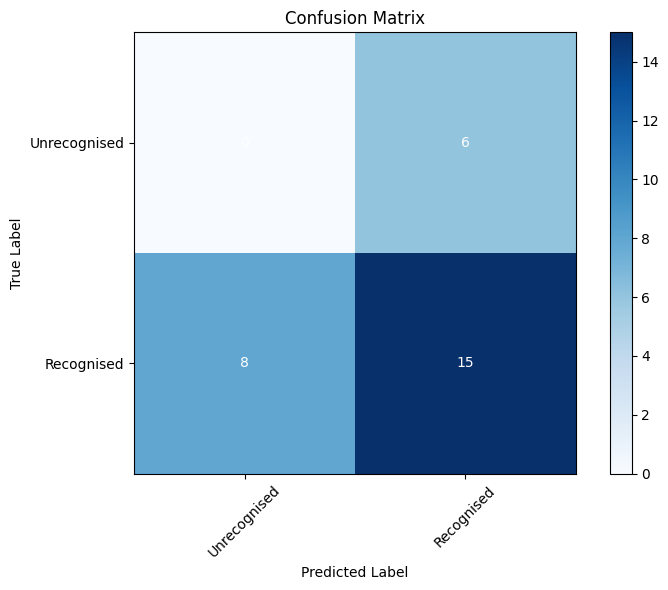

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define labels for the confusion matrix
labels = ['Unrecognised', 'Recognised']

# Create confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()


##**SVM**

In [ ]:
import pandas as pd
import pickle
import os
import face_recognition
from sklearn import svm

# Load the trained SVM model
with open("svm_model.pkl", 'rb') as f:
    svm_clf = pickle.load(f)

# Function to predict labels for each image
def predict_labels_svm(image_dir, svm_classifier):
    predictions = []

    # Loop through each image in the directory
    for i in range(29):
        image_path = os.path.join(image_dir, "face_{}.jpg".format(i))

        # Load the image
        image = face_recognition.load_image_file(image_path)

        # Find face encodings
        face_encodings = face_recognition.face_encodings(image)

        # Predict label using SVM classifier
        if len(face_encodings) == 1:
            prediction = svm_classifier.predict(face_encodings)[0]
            predictions.append(prediction)
        else:
            predictions.append("unrecognised")

    return predictions

# Directory containing cropped images
image_dir = "/content/cropped_faces2"

# Make predictions using SVM model
predicted_labels_svm = predict_labels_svm(image_dir, svm_clf)

# Create DataFrame with image names, true labels, and predicted labels
data = {
    'Image_Name': ['face{}'.format(i) for i in range(29)],
    'True_Labels': [
        '60009220088', '60009210185', 'unrecognised', '60009210164', 'unrecognised',
        '60009210157', 'unrecognised', '60009220174', '60009210196', '60009210175',
        '60009210187', '60009220194', '60009210197', '60009210206', 'unrecognised', '60009210123',
        '60009210202', '60009220175', '60009210126', '60009210156', '60009210190', '60009210192',
        'unrecognised', '60009210210', 'unrecognised', '60009210209', '60009210188',
        '60009210204', '60009220080'
    ],
    'Predicted_Labels_SVM': predicted_labels_svm
}

# Create DataFrame
df_svm_predictions = pd.DataFrame(data)

print(df_svm_predictions)

   Image_Name   True_Labels Predicted_Labels_SVM
0       face0   60009220088          60009220088
1       face1   60009210185          60009210185
2       face2  unrecognised          60009220194
3       face3    6000921064          60009210164
4       face4  unrecognised          60009210187
5       face5   60009210157          60009210157
6       face6  unrecognised          60009210123
7       face7   60009220174         unrecognised
8       face8   60009210196          60009210175
9       face9   60009210175          60009210196
10     face10   60009210187          60009210187
11     face11   60009220194          60009220194
12     face12   60009210197          60009210197
13     face13   60009210206          60009210206
14     face14  unrecognised          60009210202
15     face15   60009210123          60009210123
16     face16   60009210202         unrecognised
17     face17   60009220175          60009220175
18     face18   60009210126          60009210126
19     face19   6000

In [ ]:
df_svm_predictions

,Image_Name,True_Labels,Predicted_Labels_SVM
0,face0,60009220088,60009220088
1,face1,60009210185,60009210185
2,face2,unrecognised,60009220194
3,face3,6000921064,60009210164
4,face4,unrecognised,60009210187
5,face5,60009210157,60009210157
6,face6,unrecognised,60009210123
7,face7,60009220174,unrecognised
8,face8,60009210196,60009210175
9,face9,60009210175,60009210196


In [ ]:
# Initialize counts
TP = 0
TN = 0
FP = 0
FN = 0

# Iterate through each row in the DataFrame
for index, row in df_svm_predictions.iterrows():
    true_label = row['True_Labels']
    predicted_label = row['Predicted_Labels_SVM']

    # Check if the true label is recognised
    if 'unrecognised' in true_label.lower():
        # Check if the predicted label is also 'unrecognised'
        if 'unrecognised' in predicted_label.lower():
            TN += 1
        else:
            FP += 1
    else:
        # Check if the predicted label matches the true label
        if str(true_label) == predicted_label:
            TP += 1
        else:
            FN += 1

# Print counts
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("\n\nAccuracy:", accuracy)

# Calculate precision
precision = TP / (TP + FP)
print("Precision:", precision)

# Calculate recall
recall = TP / (TP + FN)
print("Recall:", recall)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)

# Print confusion matrix
print("\n\nConfusion Matrix:")
print("\t\tPredicted Unrecognised\tPredicted Recognised")
print("True Unrecognised\t{}\t\t\t{}".format(TN, FP))
print("True Recognised\t\t{}\t\t\t{}".format(FN, TP))

True Positives (TP): 16
True Negatives (TN): 0
False Positives (FP): 6
False Negatives (FN): 7


Accuracy: 0.5517241379310345
Precision: 0.7272727272727273
Recall: 0.6956521739130435
F1 Score: 0.711111111111111


Confusion Matrix:
		Predicted Unrecognised	Predicted Recognised
True Unrecognised	0			6
True Recognised		7			16


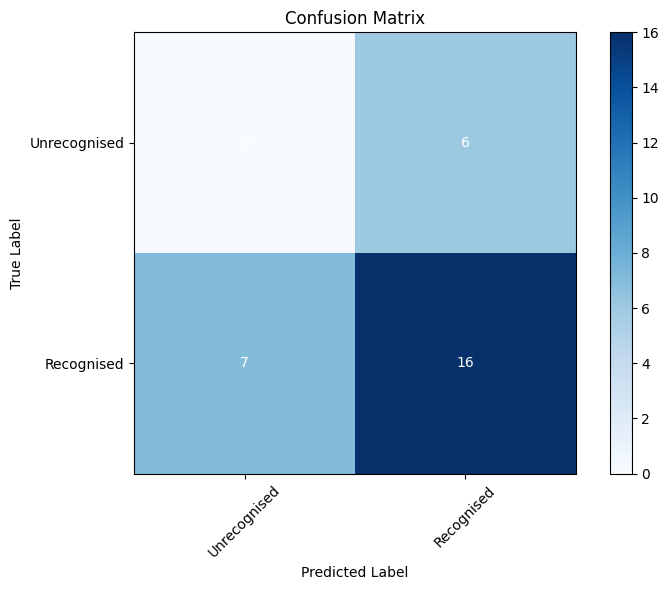

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define labels for the confusion matrix
labels = ['Unrecognised', 'Recognised']

# Create confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()


##**SVM with tuned parameters**

In [ ]:
import os
import pickle
import face_recognition
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def train_svm(train_dir, model_save_path=None, verbose=False):
    """
    Trains an SVM classifier for face recognition.

    :param train_dir: Directory that contains a sub-directory for each known person, with its name.
    :param model_save_path: (optional) Path to save the trained model on disk.
    :param verbose: Verbosity of training.
    :return: Trained SVM classifier.
    """
    encodings = []
    labels = []

    # Loop through each person in the training set
    for person_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, person_dir)):
            continue

        # Loop through each training image for the current person
        for img_name in os.listdir(os.path.join(train_dir, person_dir)):
            img_path = os.path.join(train_dir, person_dir, img_name)

            # Load the image and find face encodings
            image = face_recognition.load_image_file(img_path)
            face_encodings = face_recognition.face_encodings(image)

            # Ensure only one face is present in the image
            if len(face_encodings) == 1:
                encodings.append(face_encodings[0])
                labels.append(person_dir)
            elif len(face_encodings) < 1:
                if verbose:
                    print(f"Skipping {img_path} - No face found.")
            else:
                if verbose:
                    print(f"Skipping {img_path} - Multiple faces found.")

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5, verbose=verbose)
    grid_search.fit(encodings, labels)

    # Get the best parameters and best estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    print("Best Parameters:", best_params)

    # Save the best estimator (model)
    if model_save_path:
        with open(model_save_path, 'wb') as f:
            pickle.dump(best_estimator, f)

    return best_estimator

# Example usage:
train_dir = '/content/drive/MyDrive/Dataset'
model_save_path = 'svm_model_best_params.pkl'

print("Training SVM classifier with hyperparameter tuning...")
svm_classifier = train_svm(train_dir, model_save_path=model_save_path, verbose=True)
print("Training complete!")


Training SVM classifier with hyperparameter tuning...
Skipping /content/drive/MyDrive/Dataset/60009210202/60009210202 10.jpg - No face found.
Skipping /content/drive/MyDrive/Dataset/60009210187/60009210187 5.jpg - No face found.
Skipping /content/drive/MyDrive/Dataset/60009210190/60009210190 6.jpg - No face found.
Skipping /content/drive/MyDrive/Dataset/60009210209/60009210209 7.jpg - No face found.
Skipping /content/drive/MyDrive/Dataset/60009210209/60009210209 9.jpg - No face found.
Skipping /content/drive/MyDrive/Dataset/60009210194/60009210194 10.jpg - No face found.
Skipping /content/drive/MyDrive/Dataset/60009210156/60009210156 5.jpg - No face found.
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training complete!


In [ ]:
import pandas as pd
import pickle
import os
import face_recognition
from sklearn import svm

# Load the trained SVM model
with open("/content/svm_model_best_params.pkl", 'rb') as f:
    svm_clf = pickle.load(f)

# Function to predict labels for each image
def predict_labels_svm(image_dir, svm_classifier):
    predictions = []

    # Loop through each image in the directory
    for i in range(29):
        image_path = os.path.join(image_dir, "face_{}.jpg".format(i))

        # Load the image
        image = face_recognition.load_image_file(image_path)

        # Find face encodings
        face_encodings = face_recognition.face_encodings(image)

        # Predict label using SVM classifier
        if len(face_encodings) == 1:
            prediction = svm_classifier.predict(face_encodings)[0]
            predictions.append(prediction)
        else:
            predictions.append("unrecognised")

    return predictions

# Directory containing cropped images
image_dir = "/content/cropped_faces2"

# Make predictions using SVM model
predicted_labels_svm = predict_labels_svm(image_dir, svm_clf)

# Create DataFrame with image names, true labels, and predicted labels
data = {
    'Image_Name': ['face{}'.format(i) for i in range(29)],
    'True_Labels': [
        '60009220088', '60009210185', 'unrecognised', '60009210164', 'unrecognised',
        '60009210157', 'unrecognised', '60009220174', '60009210196', '60009210175',
        '60009210187', '60009220194', '60009210197', '60009210206', 'unrecognised', '60009210123',
        '60009210202', '60009220175', '60009210126', '60009210156', '60009210190', '60009210192',
        'unrecognised', '60009210210', 'unrecognised', '60009210209', '60009210188',
        '60009210204', '60009220080'
    ],
    'Predicted_Labels_SVM': predicted_labels_svm
}

# Create DataFrame
df_svm_predictions = pd.DataFrame(data)

print(df_svm_predictions)

   Image_Name   True_Labels Predicted_Labels_SVM
0       face0   60009220088          60009220088
1       face1   60009210185          60009210185
2       face2  unrecognised          60009220194
3       face3   60009210164          60009210164
4       face4  unrecognised          60009210187
5       face5   60009210157          60009210157
6       face6  unrecognised          60009210123
7       face7   60009220174         unrecognised
8       face8   60009210196          60009210196
9       face9   60009210175          60009210175
10     face10   60009210187          60009210187
11     face11   60009220194          60009220194
12     face12   60009210197          60009210197
13     face13   60009210206          60009210206
14     face14  unrecognised          60009210210
15     face15   60009210123          60009210123
16     face16   60009210202         unrecognised
17     face17   60009220175          60009220175
18     face18   60009210126          60009210126
19     face19   6000

In [ ]:
df_svm_predictions

,Image_Name,True_Labels,Predicted_Labels_SVM
0,face0,60009220088,60009220088
1,face1,60009210185,60009210185
2,face2,unrecognised,60009220194
3,face3,60009210164,60009210164
4,face4,unrecognised,60009210187
5,face5,60009210157,60009210157
6,face6,unrecognised,60009210123
7,face7,60009220174,unrecognised
8,face8,60009210196,60009210196
9,face9,60009210175,60009210175


In [ ]:
# Initialize counts
TP = 0
TN = 0
FP = 0
FN = 0

# Iterate through each row in the DataFrame
for index, row in df_svm_predictions.iterrows():
    true_label = row['True_Labels']
    predicted_label = row['Predicted_Labels_SVM']

    # Check if the true label is recognised
    if 'unrecognised' in true_label.lower():
        # Check if the predicted label is also 'unrecognised'
        if 'unrecognised' in predicted_label.lower():
            TN += 1
        else:
            FP += 1
    else:
        # Check if the predicted label matches the true label
        if str(true_label) == predicted_label:
            TP += 1
        else:
            FN += 1

# Print counts
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("\n\nAccuracy:", accuracy)

# Calculate precision
precision = TP / (TP + FP)
print("Precision:", precision)

# Calculate recall
recall = TP / (TP + FN)
print("Recall:", recall)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)

# Print confusion matrix
print("\n\nConfusion Matrix:")
print("\t\tPredicted Unrecognised\tPredicted Recognised")
print("True Unrecognised\t{}\t\t\t{}".format(TN, FP))
print("True Recognised\t\t{}\t\t\t{}".format(FN, TP))

True Positives (TP): 19
True Negatives (TN): 0
False Positives (FP): 6
False Negatives (FN): 4


Accuracy: 0.6551724137931034
Precision: 0.76
Recall: 0.8260869565217391
F1 Score: 0.7916666666666667


Confusion Matrix:
		Predicted Unrecognised	Predicted Recognised
True Unrecognised	0			6
True Recognised		4			19


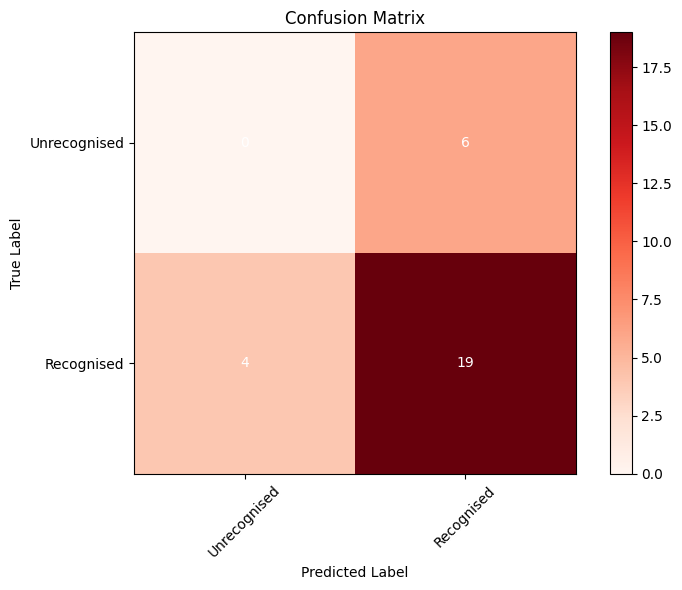

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define labels for the confusion matrix
labels = ['Unrecognised', 'Recognised']

# Create confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

In [ ]:
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.

    :param train_dir: directory that contains a sub-directory for each known person, with its name.

     (View in source code to see train_dir example tree structure)

     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...

    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf